In [120]:
import numpy as np
import matplotlib . pyplot as plt

In [121]:
def read_csv ( csv_path ):
    np_path_XYs = np . genfromtxt( csv_path , delimiter =',')
    path_XYs = []
    for i in np . unique ( np_path_XYs [: , 0]):
        npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
        XYs = []
        for j in np . unique ( npXYs [: , 0]):
            XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
            XYs . append ( XY )
        path_XYs . append ( XYs )
    return path_XYs


def plot ( path_XYs ):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    fig , ax = plt . subplots ( tight_layout = True , figsize =(8 , 8))
    for i , XYs in enumerate ( path_XYs ):
        c = colours [ i % len ( colours )]
        for XY in XYs :
            ax . plot ( XY [: , 0] , XY [: , 1] , c =c , linewidth =2)
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    plt . show ()
    
    
def plot_points(path_XYs):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.scatter(XY[:, 0], XY[:, 1], c=c, s=3) 
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yticks([0, 50, 100, 150, 200])
    plt.show()

<class 'list'>
8


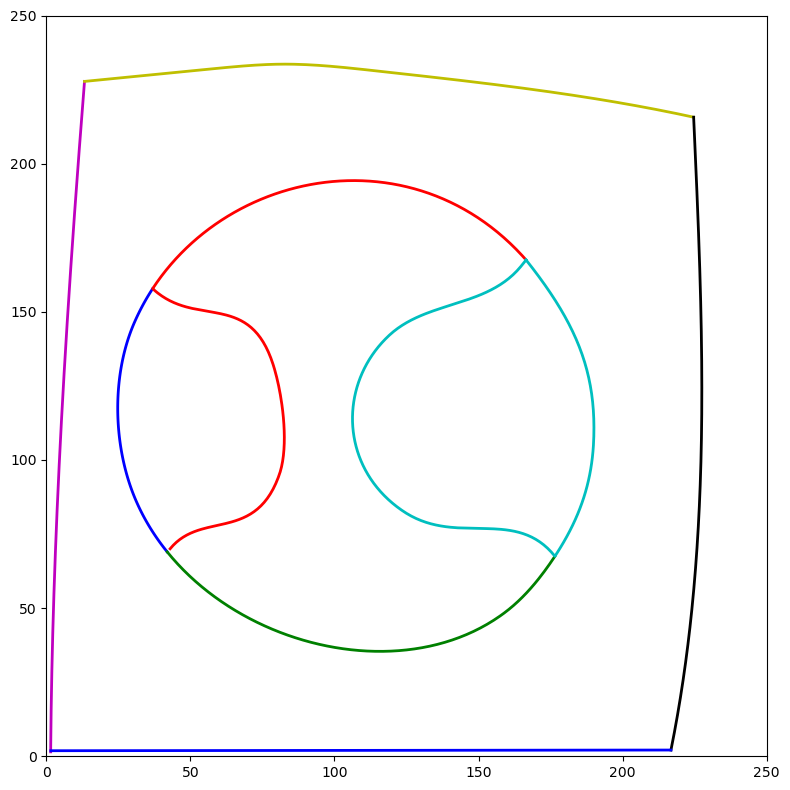

In [122]:
shape = read_csv("resources/frag1.csv")
print(type(shape))
print(len(shape))
shape
plot(shape)

In [123]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler

def detect_line(points_list,threshold = 0.1):
    points = points_list[0]
    
    x = points[:, 0]
    y = points[:, 1]
    
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    distances = np.abs(m * x - y + c) / np.sqrt(m**2 + 1)
    
    distance_between_first_last = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    
    tolerance = threshold * distance_between_first_last

    if np.max(distances) < tolerance:
        return True, m, c
    return False, None, None



def fit_circular_arc(points, tolerance=2):
    points = points[0]
    n_points = len(points)
    
    if n_points < 10:
        return False, None
    
    ten_percent = n_points // 10
    indices = np.concatenate([
        np.arange(ten_percent),
        np.arange(n_points//2 - ten_percent//2, n_points//2 + ten_percent//2),
        np.arange(n_points - ten_percent, n_points)
    ])
    selected_points = points[indices]
    
    x, y = selected_points[:, 0], selected_points[:, 1]
    
    def calculate_center(x, y):
        A = np.vstack([x, y, np.ones(len(x))]).T
        b = x**2 + y**2
        sol = np.linalg.lstsq(A, b, rcond=None)[0]
        cx, cy = sol[0] / 2, sol[1] / 2
        r = np.sqrt(sol[2] + cx**2 + cy**2)
        return cx, cy, r
    
    cx, cy, r = calculate_center(x, y)
    
    distances = np.sqrt((x - cx)**2 + (y - cy)**2)
    if np.all(np.abs(distances - r) <= tolerance):
        rest_indices = np.setdiff1d(np.arange(n_points), indices)
        rest_points = points[rest_indices]
        rest_distances = np.sqrt((rest_points[:, 0] - cx)**2 + (rest_points[:, 1] - cy)**2)
        if np.all(np.abs(rest_distances - r) <= tolerance):
            return True, cx, cy
    
    return False, None, None


def compute_curvature_points(points_list,threshold = 0.35):
    points = points_list[0]
    points = np.array(points, dtype=float)  
    dx_dt = np.gradient(points[:, 0])
    dy_dt = np.gradient(points[:, 1])

    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5

    high_curvature_indices = np.where(curvature > threshold)[0]

    high_curvature_indices = np.append(high_curvature_indices, [0, len(points) - 1])

    high_curvature_indices = np.unique(high_curvature_indices)

    return high_curvature_indices
    
    
def split_points(points, high_curvature_indices):
    segments = []

    start_index = high_curvature_indices[0]

    for i in range(1, len(high_curvature_indices)):
        end_index = high_curvature_indices[i]
        if end_index - high_curvature_indices[i-1] > 1:
            segments.append(points[start_index:end_index + 1])
            start_index = end_index

    if start_index < len(points):
        segments.append(points[start_index:])

    return [np.array(segment) for segment in segments[:-1]]  



In [124]:
def process_shape(shape):
    new_shape = []
    for s in shape:
        high_curvature_indices = compute_curvature_points(s)
        if len(high_curvature_indices) > 2:
            segments = split_points(s, high_curvature_indices)  
            for seg in segments:
                new_shape.append([seg])  
        else:
            new_shape.append(s)  

    return new_shape




line = []
circle = []
circle_centers = [] 
other = []
slope = []

for s in shape:
    is_line, m, c = detect_line(s)
    if is_line:
        line.append(s)
        slope.append(m)
    else:
        is_circle, cx, cy = fit_circular_arc(s)
        if is_circle:
            circle.append(s)
            circle_centers.append((cx, cy))  
        else:
            other.append(s)



In [125]:
def detect_circle(circle_centers, arcs):
    mean_center = np.mean(circle_centers, axis=0)
    
    def are_points_close(p1, p2, tolerance=5):
        return np.linalg.norm(np.array(p1) - np.array(p2)) <= tolerance
    
    def merge_arcs(arcs):
        merged_arcs = []
        while arcs:
            i = 0
            while i < len(arcs):
                arc_to_compare = arcs[i][0].tolist()
                if are_points_close(arc[-1], arc_to_compare[0]):
                    arc.extend(arc_to_compare)
                    arcs.pop(i)
                elif are_points_close(arc[-1], arc_to_compare[-1]):
                    arc.extend(arc_to_compare[::-1])
                    arcs.pop(i)
                elif are_points_close(arc[0], arc_to_compare[-1]):
                    arc = arc_to_compare + arc
                    arcs.pop(i)
                elif are_points_close(arc[0], arc_to_compare[0]):
                    arc = arc_to_compare[::-1] + arc
                    arcs.pop(i)
                else:
                    i += 1
        return merged_arcs
    
    grouped_arcs = []
    for i, arc in enumerate(arcs):
        if are_points_close(circle_centers[i], mean_center, tolerance=10):
            grouped_arcs.append(arc)
    
    merged_arcs = merge_arcs(grouped_arcs)
    
    return merged_arcs


c = detect_circle(circle_centers,circle)
plot([c])

UnboundLocalError: cannot access local variable 'arc' where it is not associated with a value

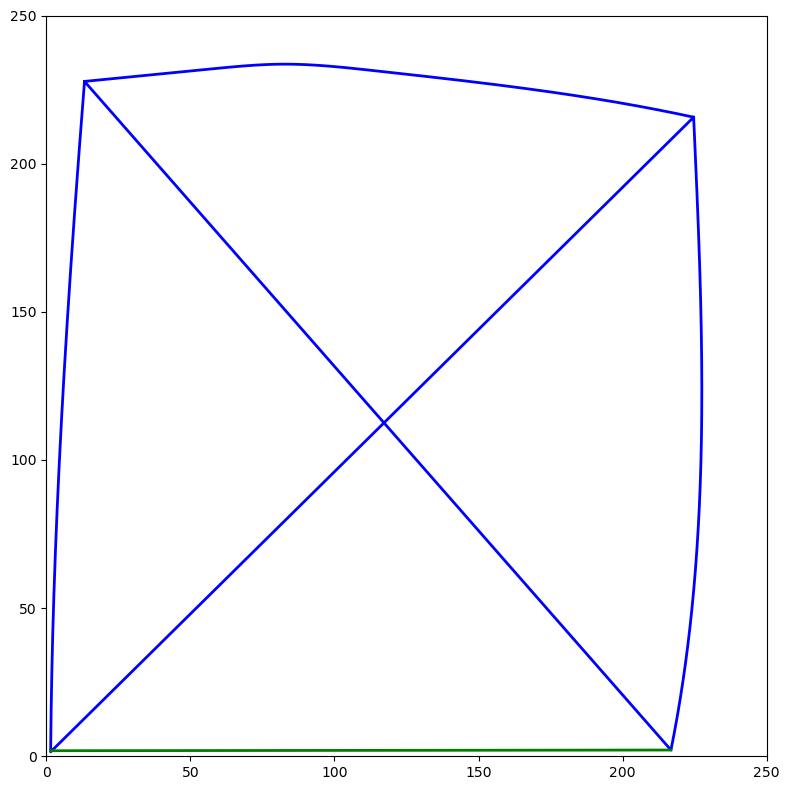

In [ ]:

def merge(line, order):
    merged_lines = []
    merged_points = []
    for index in order:
        merged_points.extend(line[index][0])
    merged_lines.append([np.array(merged_points)])
    for i in range(len(line)):
        if i not in order:
            merged_lines.append(line[i])

    return merged_lines

l=merge(line,[0,1,2])



In [ ]:
def angle(line_1, line_2):
    p1_start, p1_end = line_1[0][0], line_1[0][-1]
    p2_start, p2_end = line_2[0][0], line_2[0][-1]
    vec1 = p1_end - p1_start
    vec2 = p2_end - p2_start
    dot_product = np.dot(vec1, vec2)
    mag1 = np.linalg.norm(vec1)
    mag2 = np.linalg.norm(vec2)
    cos_angle = dot_product / (mag1 * mag2)
    cos_angle = np.clip(cos_angle, -1, 1)
    angle_rad = np.arccos(cos_angle)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def is_connected(line_1, line_2, threshold=3):
    start_i, end_i = line_1[0][0], line_1[0][-1]
    start_j, end_j = line_2[0][0], line_2[0][-1]
    
    return (np.allclose(start_i, start_j, atol=threshold) or
            np.allclose(start_i, end_j, atol=threshold) or
            np.allclose(end_i, start_j, atol=threshold) or
            np.allclose(end_i, end_j, atol=threshold))
    
    
def detect_rect(lines, connection_threshold=3):
    rect_lines = [[] for _ in range(len(lines))]

    for i in range(len(lines)):
        for j in range(len(lines)):
            if i != j:
                ang = angle(lines[i], lines[j])
                if 85 <= ang <= 95 and is_connected(lines[i], lines[j], threshold=connection_threshold):
                    rect_lines[i].append(j)

    def find(parent, i):
        if parent[i] == i:
            return i
        else:
            parent[i] = find(parent, parent[i]) 
            return parent[i]

    def union(parent, rank, x, y):
        root_x = find(parent, x)
        root_y = find(parent, y)

        if root_x != root_y:
            if rank[root_x] > rank[root_y]:
                parent[root_y] = root_x
            elif rank[root_x] < rank[root_y]:
                parent[root_x] = root_y
            else:
                parent[root_y] = root_x
                rank[root_x] += 1

    parent = list(range(len(lines)))
    rank = [0] * len(lines)

    for i in range(len(rect_lines)):
        for j in rect_lines[i]:
            union(parent, rank, i, j)

    groups = {}
    for i in range(len(parent)):
        root = find(parent, i)
        if root not in groups:
            groups[root] = []
        groups[root].append(i)

    merged_rects = []
    for group in groups.values():
        merged_line = np.concatenate([lines[i][0] for i in group], axis=0)
        merged_rects.append([merged_line])

    return merged_rects

    
    
l = detect_rect(line)
l

[[array([[ 13.24499989, 227.75500488],
         [ 13.16392899, 226.75363159],
         [ 13.08298397, 225.75216675],
         ...,
         [214.76663208,   2.10484123],
         [215.77230835,   2.10592055],
         [216.77799988,   2.10700011]])]]

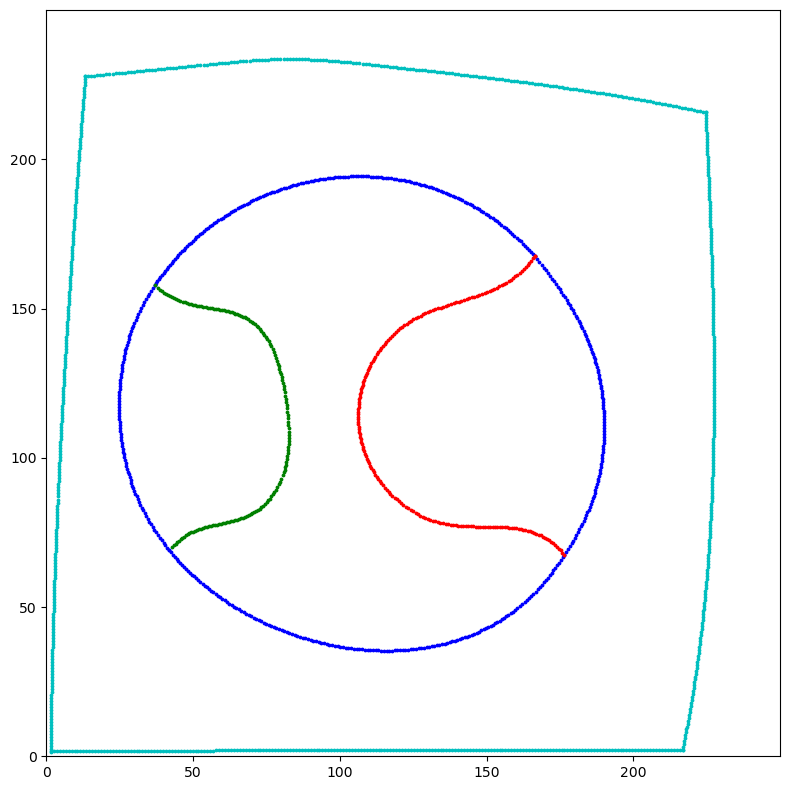

In [ ]:
ans = []
ans.append(c)
ans.append(other[0])
ans.append(other[1])
ans.append(l[0])
plot_points(ans)